<a href="https://colab.research.google.com/github/OrangeAoo/AI/blob/main/HW1_TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

## Introduction

The IMDb Movie Reviews dataset is a collection of 50,000 reviews from IMDb that are labeled as either positive or negative. The dataset is used for binary sentiment analysis, and it contains an equal number of positive and negative reviews.

In this assignment, we will walk through three text classification pipelines on classifying IMDB moview review sentiment:
1. Training a simple model from scratch
2. Fine-tuning embeddings from a pre-trained BERT model
3. Using an out-of-the-box zero-shot LLM


**Your task**
## Problem 1:

Using the simple model provided in the Colab notebook, which is the same model discussed in class, modify the code by adding a hidden layer between the averaged embedding and the final logits. Use a ReLU activation function for this hidden layer, and set its dimension to 128.

  

1. [2 pts] Calculate the number of trainable parameters in your modified model.

  

2. [1 pt] Run the classification pipeline with your modified model and report the **accuracy** and **loss** after 10 epochs.

  

3. [2 pts] Increase the batch size from 128 to 1024 and run the classification pipeline again (ensure to reinitialize your model). What differences do you observe in the results, and how would you explain these changes?

  
  

## Problem 2

Modify the code for fine-tuning using BERT.

  

1. [2 pts] Freeze the base model (making its parameters non-trainable) and add a hidden layer (with a dimension size of 128) with a ReLU activation function, similar to what was done in Problem 1. Report the accuracy and loss after 2 epochs.

  

2. [1 pt] Provide an explanation for any improvements observed in Problem 2 compared to Problem 1.

  

## Problem 3

Modify the code for Zero-shot LLM text classification. You may check the code in the [notebook](https://colab.research.google.com/drive/1ZLrXVNxq7V082NvHWp5vMoI8hxfi9Bpv?usp=sharing) from Lecture 2 as well.

  

1. [2 pts] Optimize the prompt as much as possible (e.g., by applying the chain of thought method discussed in the lecture). Run your optimized prompt with 1000 test samples. Report both the optimized prompt and the resulting accuracy.


# Dataset Preparation

First we will load the IMDB dataset, which contains text and binary labels.

In [ ]:
!pip install -q datasets

Load IMDB dataset

In [ ]:
from datasets import load_dataset
from tqdm import tqdm

imdb = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_texts_raw = imdb['train']['text']
test_texts_raw = imdb['test']['text']
train_labels_raw = imdb['train']['label']
test_labels_raw = imdb['test']['label']

Let's shuffle the data and select 10000 samples for training and 1000 samples for testing (for homework purpose)

In [ ]:
import numpy as np
np.random.seed(42)
train_indices = np.random.choice(len(train_texts_raw), 10000)
test_indices = np.random.choice(len(test_texts_raw), 1000)
train_texts = np.array(train_texts_raw)[train_indices].tolist()
test_texts = np.array(test_texts_raw)[test_indices].tolist()
train_labels = np.array(train_labels_raw)[train_indices].tolist()
test_labels = np.array(test_labels_raw)[test_indices].tolist()
len(train_texts), len(test_texts) # the size of train vs test

(10000, 1000)

Let's take a look for an example, label `1` indicates positive and label `0` indicates negative.

In [ ]:
train_texts[1], train_labels[1]

("Went to see this finnish film and I've got to say that it is one of the better films I've seen this year. The intrigue is made up of 5-6 different stories, all taking place the very same day in a small finnish town. The stories come together very nicely in the end, reminding, perhaps, a bit of the way Tarantino's movies are made. Most of the actors performed very well, which most certainly is needed in realistic dramas of this type. I especially enjoyed the acting by Sanna Hietala, the lead actress, and Juha Kukkonen. I noticed btw that IMDB has got the wrong information about Sanna. Her name, as you might have noticed in my review ;), is NOT Heikkilä, but Hietala.",
 1)

## A simple model

### Tokenization
To begin, we need a tokenizer that can map a text to a sequence of integers (and vice-versa).

Here we are going to borrow the tokenizer from `Bert` directly. This tokenizer was trained on a large corpus of English texts to automatically learn subwords (another example of data-driven spirit!).

Download the tokenizer (one line of code thanks to Huggingface).

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encode a text and obtain a sequence of integers, each integer is called a `token`.

In [ ]:
tokenizer.encode('hello world', return_tensors='pt')

tensor([[ 101, 7592, 2088,  102]])

### Model Architecture

We build a very simple model that akins to `bag of words` method.

We map each word (be more precise, token) to an embedding and then average all embeddings to get a sentence-level embedding. Then an linear layer will be used to extract the output (akin to logisitc regression).

The token embeddings and parameters of the linear layer will be trained at the same time, using cross entropy loss (with logits).

The model is constructed through the class `EmbeddingModel`.

### Problem 1:
Using the simple model below, which is the same model discussed in class, modify the code by adding a hidden layer between the averaged embedding and the final logits. Use a ReLU activation function for this hidden layer, and set its dimension to 128.

  

1. [2 pts] Calculate the number of trainable parameters in your modified model.

  

2. [1 pt] Run the classification pipeline with your modified model and report the **accuracy** and **loss** after 10 epochs.

  

3. [2 pts] Increase the batch size from 128 to 1024 and run the classification pipeline again (ensure to reinitialize your model). What differences do you observe in the results, and how would you explain these changes?


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, num_classes)

    def forward(self, inputs):
        output = self.embedding(inputs)
        output = torch.mean(output, dim=1)  # Mean pooling
        output = self.fc1(output)
        return output

model = EmbeddingModel(tokenizer.vocab_size, 128, 128, 2)

You can test that whether the output dimension is what we want.

In [ ]:
inputs = tokenizer.encode('hello world', return_tensors='pt')
model(inputs)

tensor([[0.0499, 0.0916]], grad_fn=<AddmmBackward0>)

A helper function for training the model

In [ ]:
def train_model(num_epochs, batch_size, max_length, model, optimizer):


    loss_fn = nn.CrossEntropyLoss() ## loss_fn(logits, target) will take K-dim logits and a target index in [0..K-1] that indicates the true class
    train_accuracy_list = []
    test_accuracy_list = []
    train_loss_list = []
    test_loss_list = []


    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        ### training
        model.train()
        for batch in tqdm(range(0, len(train_texts), batch_size)):
            input = train_texts[batch:batch+batch_size]
            labels = train_labels[batch:batch+batch_size]

            input = tokenizer(input, padding=True, truncation=True, max_length=max_length, return_tensors='pt') # Question: why do we need padding and truncation?
            labels = torch.tensor(labels)

            logits = model(input["input_ids"])
            loss = loss_fn(logits, labels)

            train_loss += loss.item() * len(labels)
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

            ### taking gradient descent on this batch
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_texts)}")
        print(f"Train Accuracy: {train_accuracy/len(train_texts)}")
        train_accuracy_list.append(train_accuracy/len(train_texts))
        train_loss_list.append(train_loss/len(train_texts))

        ### testing
        test_loss = 0.0
        test_accuracy = 0.0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(range(0, len(test_texts), batch_size)):
                input = test_texts[batch:batch+batch_size]
                labels = test_labels[batch:batch+batch_size]
                input = tokenizer(input, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
                labels = torch.tensor(labels)

                logits = model(input["input_ids"])
                loss = loss_fn(logits, labels)
                test_loss += loss.item() * len(labels)
                test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        print(f"Test Loss: {test_loss/len(test_texts)}")
        print(f"Test Accuracy: {test_accuracy/len(test_texts)}")
        test_accuracy_list.append(test_accuracy/len(test_texts))
        test_loss_list.append(test_loss/len(test_texts))

    return train_accuracy_list, test_accuracy_list, train_loss_list, test_loss_list, model

Kick off training

In [ ]:
num_epochs = 10
batch_size = 128
max_length = 512
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_accuracy_list, test_accuracy_list, train_loss_list, test_loss_list, model = train_model(num_epochs, batch_size, max_length, model, optimizer)

Epoch 1/10, Loss: 0.6905236075401306
Train Accuracy: 0.5256
Test Loss: 0.682772352218628
Test Accuracy: 0.56
Epoch 2/10, Loss: 0.656630800819397
Train Accuracy: 0.6215
Test Loss: 0.6163395071029663
Test Accuracy: 0.671
Epoch 3/10, Loss: 0.5487612312793732
Train Accuracy: 0.7395
Test Loss: 0.49802234745025636
Test Accuracy: 0.793
Epoch 4/10, Loss: 0.42274134278297426
Train Accuracy: 0.8244
Test Loss: 0.41701280093193055
Test Accuracy: 0.825
Epoch 5/10, Loss: 0.3305585817813873
Train Accuracy: 0.8697
Test Loss: 0.37124239444732665
Test Accuracy: 0.835
Epoch 6/10, Loss: 0.2673660098731518
Train Accuracy: 0.8985
Test Loss: 0.344688395023346
Test Accuracy: 0.852
Epoch 7/10, Loss: 0.2208690035045147
Train Accuracy: 0.9196
Test Loss: 0.3285403985977173
Test Accuracy: 0.86
Epoch 8/10, Loss: 0.18470427219569682
Train Accuracy: 0.9352
Test Loss: 0.32198233270645144
Test Accuracy: 0.873
Epoch 9/10, Loss: 0.15545043005347253
Train Accuracy: 0.9473
Test Loss: 0.31545541524887083
Test Accuracy: 0.87

Accuracy plot as epoch increases.

In [ ]:
### plot the train and test accuracy

import matplotlib.pyplot as plt

plt.plot(train_accuracy_list, label='train_accuracy')
plt.plot(test_accuracy_list, label='test_accuracy')
plt.legend()

### Fine-tune Pre-trained Embedding Model

A paragraph-level embedding may capture the contexts better than word-level embeddings.

Here we use a pre-trained model (Bert-base) to provide us a paragraph-level embedding.

We just need one line to download Bert-base, which has 110M parameters and was trained on the Toronto BookCorpus (800M words) and English Wikipedia (2,500M words)

Celebrate the spirit of open-source models!

In [ ]:
## download Bert
import torch
from transformers import BertTokenizer, BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

We also donwload the tokenizer again and make the tokenizer is consistent with the bert model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


We build the ClassificationModel with Bert as a base_model.

We freeze the base model parameters except last two layers so that we are not changing most parameters while fine-tuning.


### Problem 2

Modify the code for fine-tuning using BERT.

  

1. [2 pts] Freeze the base model (making its parameters non-trainable) and add a hidden layer (with a dimension size of 128) with a ReLU activation function, similar to what was done in Problem 1. Report the accuracy and loss after 2 epochs.

  

2. [1 pt] Provide an explanation for any difference observed in Problem 2 compared to Problem 1.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationModel(nn.Module):
    def __init__(self, base_model, embedding_dim, hidden_dim, num_classes, freeze_base_model=True):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, num_classes)
        self.base_model = base_model

    def forward(self, inputs):
        outputs = self.base_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :] #embedding of the first token (cls_token, which is a special token that provides paragraph-level embedding)
        logits = self.fc1(cls_embedding)
        return logits

Create a model and move the model to GPU memory

In [ ]:
model = ClassificationModel(bert_model, 768, 128, 2)
model = model.to('cuda') # we need to move model to cuda to use GPU

Test whether the output dimension is correct

In [ ]:
input = tokenizer(['hello world', 'go go power'], return_tensors='pt', padding=True, truncation=True, max_length=4)
input = input.to('cuda')
print(model(input))

tensor([[ 0.0462,  0.0228],
        [ 0.0730, -0.0898]], device='cuda:0', grad_fn=<AddmmBackward0>)


The input actually includes `input_ids` and `attention_mask`. We will explain their meanings later when we talk about transformers.

Kickoff training.

To run the following code, we suggest you switch to L4 GPU (about 3min per epoch) or A100 GPU (about 2min per epoch). After you switch the code, you need to rerun the data processing. Check [here](https://saturncloud.io/blog/how-to-activate-gpu-computing-in-google-colab/) for instructions.

In [ ]:

num_epochs = 2
batch_size = 128
max_length = 512


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_accuracy_list = []
test_accuracy_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    model.train()
    for batch in tqdm(range(0, len(train_texts), batch_size)):
        input = train_texts[batch:batch+batch_size]
        labels = train_labels[batch:batch+batch_size]

        input = tokenizer(input, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        labels = torch.tensor(labels)

        input = input.to('cuda')
        labels = labels.to('cuda')
        logits = model(input)
        loss = nn.CrossEntropyLoss()(logits, labels)

        train_loss += loss.item() * len(labels)
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_texts)}")
    print(f"Train Accuracy: {train_accuracy/len(train_texts)}")
    train_accuracy_list.append(train_accuracy/len(train_texts))
    train_loss_list.append(train_loss/len(train_texts))

    test_loss = 0.0
    test_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(range(0, len(test_texts), batch_size)):
            input = test_texts[batch:batch+batch_size]
            labels = test_labels[batch:batch+batch_size]
            input = tokenizer(input, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
            labels = torch.tensor(labels)
            input = input.to('cuda')
            labels = labels.to('cuda')
            logits = model(input)
            loss = nn.CrossEntropyLoss()(logits, labels)
            test_loss += loss.item() * len(labels)
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    print(f"Test Loss: {test_loss/len(test_texts)}")
    print(f"Test Accuracy: {test_accuracy/len(test_texts)}")
    test_accuracy_list.append(test_accuracy/len(test_texts))
    test_loss_list.append(test_loss/len(test_texts))

100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch 1/2, Loss: 0.19274951703548432
Train Accuracy: 0.9214


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


Test Loss: 0.2132639878988266
Test Accuracy: 0.924


100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


Epoch 2/2, Loss: 0.17205181368887423
Train Accuracy: 0.9331


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]

Test Loss: 0.22460264229774476
Test Accuracy: 0.926


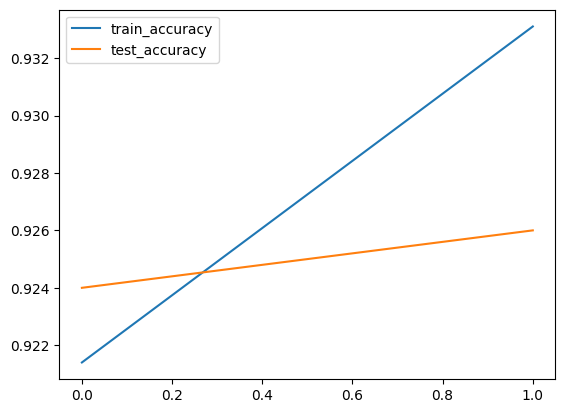

In [ ]:
### plot the train and test accuracy
from matplotlib import pyplot as plt
plt.plot(train_accuracy_list, label='train_accuracy')
plt.plot(test_accuracy_list, label='test_accuracy')
plt.legend()

## LLM-based zero-shot classification

Next, we are going to demo how to use LLM to do text classification without any training.

Let's start with installing the package.

llm-batch-helper (https://pypi.org/project/llm_batch_helper/) is a package that calling LLMs with parallelization, caching, and retry functionality.

In [ ]:
!pip install llm-batch-helper==0.3.2

  Attempting uninstall: llm-batch-helper
    Found existing installation: llm_batch_helper 0.3.1
    Uninstalling llm_batch_helper-0.3.1:
      Successfully uninstalled llm_batch_helper-0.3.1


An example of using the llm_batch_helper package.

Here we suggest the usage of OpenRouter for calling LLMs. OpenRouter provides a universal account for invoking various LLMs. Sometimes free tokens might be offered for state-of-the-art models (e.g., https://openrouter.ai/moonshotai/kimi-k2:free).

In [ ]:
from llm_batch_helper import LLMConfig, process_prompts_batch  # docs show these symbols

# Docs: async process_prompts_batch(prompts, config=..., provider="openai", cache_dir=..., force=False)
#       LLMConfig(model_name=..., system_instruction=..., max_concurrent_requests=..., **kwargs)
# See: https://llm-batch-helper.readthedocs.io/en/latest/api.html

### setup OpenRouter api key
import os
os.environ['OPENROUTER_API_KEY'] = ""



prompts = [
    "What is the capital of France?",
    "What is 2+2?",
    "Who wrote 'Hamlet'?"
]
cache_dir = 'llm_cache'

config = LLMConfig(
    model_name="gpt-5-mini",
    system_instruction="You are a helpful assistant.",
    temperature=1.0,                           # match deterministic-ish behavior
    max_concurrent_requests=30,              # maximal number of paralleizing requests
    max_retries=5,                           # maximal number of retries per request
    # Pass through OpenAI-style extras via **kwargs supported by LLMConfig
    seed=42
)

# Run batch; returns dict: {prompt_id: {"response_text": str, ...}}
results = process_prompts_batch(
    prompts=prompts,
    provider="openrouter",
    config=config,
    cache_dir=cache_dir,     # set to use caching; or None to disable
    desc="Classifying"
)

# Print results
print()
for prompt_id, response in results.items():
    print(f"{prompt_id}: {response['response_text']}") #prompt_id is the hash of the prompt for cache identification

Classifying: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


115049a298532be2f181edb03f766770: The capital of France is Paris.
52cb6b5e4a038af1756708f98afb718a: 2 + 2 = 4.
baa758cc1a9876b21fab4d9b07f03e9b: "Hamlet" was written by William Shakespeare. It is one of his tragedies, written around 1600–1601 and first published in 1603 (folio/ quartos thereafter).


Let's write a helper function to enumerate all texts and call OpenAI api to get the respones.

In [ ]:
import json
from typing import List, Union

def classify(texts: List[str], prompt: str):
    """
    texts: list of inputs
    prompt: template string containing {text}
    max_concurrency: parallel requests via llm-batch-helper
    cache_dir: optional on-disk cache directory (e.g., '.llm_cache')
    """
    # Build prompts with stable IDs so results can be re-ordered reliably
    prompts = [(str(i), prompt.format(text=t)) for i, t in enumerate(texts)] # here prompt_id is user-defined (prompt_id is str(i))

    config = LLMConfig(
        model_name="gpt-5-mini",
        system_instruction="You are a helpful assistant.",
        temperature=1.0,                           # match deterministic-ish behavior
        max_concurrent_requests=30,              # maximal number of paralleizing requests
        max_retries=5,                           # maximal number of retries per request
        # Pass through OpenAI-style extras via **kwargs supported by LLMConfig
        response_format={"type": "json_object"},
        seed=42
    )

    # Run batch; returns dict: {prompt_id: {"response_text": str, ...}}
    results = process_prompts_batch(
        prompts=prompts,
        provider="openrouter",
        config=config,
        cache_dir='.llm_cache',     # set to use caching; or None to disable
        desc="Classifying"
    )

    # Restore original order and JSON-decode if possible
    return results

### Problem 3


Modify the code for Zero-shot LLM text classification. You may check the code in the [notebook](https://colab.research.google.com/drive/1ZLrXVNxq7V082NvHWp5vMoI8hxfi9Bpv?usp=sharing) from Lecture 2 as well.

  

1. [2 pts] Optimize the prompt as much as possible (e.g., by applying the chain of thought method discussed in the lecture). Run your optimized prompt with 1000 test samples. Report both the optimized prompt and the resulting accuracy.


Here is a prompt example.

For the JSON format output, you may check [here](https://platform.openai.com/docs/guides/structured-outputs/introduction) for a better way of handling structure output, but the following approach is more explicit.


In [ ]:
prompt = '''
You are given a movie review text and you need to classify it into positive or negative.

Your response should be a JSON object with the following format:
{{
    "Sentiment": "Positive" or "Negative"
}}

The text is below:
Text: {text}
'''

In [ ]:
results = classify(test_texts[:10], prompt) # You can first test/tune over 10 samples, and then run 1000 samples.


# Print results
print()
for prompt_id, response in results.items():
    print(f"{prompt_id}: {response['response_text']}") #prompt_id is the hash of the prompt for cache identification

Classifying: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

{'0': {'response_text': '{\n    "Sentiment": "Negative"\n}', 'usage_details': {'prompt_token_count': 447, 'completion_token_count': 16, 'total_token_count': 463}}, '1': {'response_text': '{\n    "Sentiment": "Negative"\n}', 'usage_details': {'prompt_token_count': 922, 'completion_token_count': 80, 'total_token_count': 1002}}, '2': {'response_text': '{\n    "Sentiment": "Negative"\n}', 'usage_details': {'prompt_token_count': 229, 'completion_token_count': 80, 'total_token_count': 309}}, '3': {'response_text': '{\n    "Sentiment": "Negative"\n}', 'usage_details': {'prompt_token_count': 312, 'completion_token_count': 272, 'total_token_count': 584}}, '4': {'response_text': '{\n    "Sentiment": "Positive"\n}', 'usage_details': {'prompt_token_count': 304, 'completion_token_count': 16, 'total_token_count': 320}}, '5': {'response_text': '{"Sentiment": "Negative"}', 'usage_details': {'prompt_token_count': 157, 'completion_token_count': 77, 'total_token_count': 234}}, '6': {'response_text': '{\n

Take a look for the output: it is a desired dictionary

Write a helper function to compute the accuracy score

In [ ]:
def accuracy_score(results, texts, labels):
    accuracy = 0
    for i, (prompt_id, result) in enumerate(results.items()):
        classification = json.loads(result['response_text'])['Sentiment']
        if classification == 'Positive' and labels[i] == 1 or classification == 'Negative' and labels[i] == 0:
            accuracy += 1

    return accuracy/len(results)

In [ ]:
accuracy = accuracy_score(results, test_texts, test_labels)
print("accuracy:", accuracy)

accuracy: 0.9
